## Home assignment: Feature importances

Your goal is to estimate importance of the existing features using several methods.

Your main goal is to estimate feature importances for Logistic Regression and Gradient Boosting using several methods.

In this task you meet the [dataset](https://archive.ics.uci.edu/ml/datasets/Statlog+%28Vehicle+Silhouettes%29) describing different cars for multiclass ($k=4$) classification problem, but we use only binary subset for classes `bus` and `opel`.

In [11]:
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [8]:
dataset = pd.read_csv("car_data.csv", delimiter=",", header=None, index_col=0)
dataset.head(5)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,,,,,,,,,,,,,,,,,,,
0,95,48,83,178,72,10,162,42,20,159,176,379,184,70,6,16,187,197,van
1,91,41,84,141,57,9,149,45,19,143,170,330,158,72,9,14,189,199,van
2,104,50,106,209,66,10,207,32,23,158,223,635,220,73,14,9,188,196,saab
3,93,41,82,159,63,9,144,46,19,143,160,309,127,63,6,10,199,207,van
4,85,44,70,205,103,52,149,45,19,144,241,325,188,127,9,11,180,183,bus


In [9]:
dataset = dataset.values

data = dataset[:, :-1].astype(int)
target = dataset[:, -1]

binary_subset = np.array([x in ["bus", "opel"] for x in target])
data, target = data[binary_subset], target[binary_subset]

print(data.shape, target.shape)

(430, 18) (430,)


In [10]:
submission_dict = {}

In [12]:
# split the dataset
X_train, X_val, y_train, y_val = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

In [13]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(344, 18) (344,) (86, 18) (86,)


In [14]:
np.unique(y_train)

array(['bus', 'opel'], dtype=object)

#### Estimating features importances using logistic regression coefficients.
Train basic logistic regression and save its coefficients (weights).

In [15]:
lr_basic = LogisticRegression(solver="liblinear")
lr_basic.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

Check the classification results on the original train data:

In [16]:
print(classification_report(y_train, lr_basic.predict(X_train)))

              precision    recall  f1-score   support

         bus       0.99      0.99      0.99       174
        opel       0.99      0.99      0.99       170

    accuracy                           0.99       344
   macro avg       0.99      0.99      0.99       344
weighted avg       0.99      0.99      0.99       344



And on validation:

In [17]:
print(classification_report(y_val, lr_basic.predict(X_val)))

              precision    recall  f1-score   support

         bus       0.96      1.00      0.98        44
        opel       1.00      0.95      0.98        42

    accuracy                           0.98        86
   macro avg       0.98      0.98      0.98        86
weighted avg       0.98      0.98      0.98        86



Find the Logistic Regression weights and save them to the variable `lr_basic_coef`:

In [18]:
lr_basic_coef = lr_basic.coef_

It should have the same number of coefficients as number of features.

In [19]:
assert lr_basic_coef.shape[-1] == X_train.shape[1]

In [20]:
submission_dict["lr_basic_coef"] = lr_basic_coef

#### Estimating features importances using logistic regression coefficients.
Train basic logistic regression on scaled data and save its coefficients (weights) as well

In [21]:
lr_scaled = LogisticRegression(solver="liblinear")

Use `StandardScaler` on your data.

In [22]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [23]:
lr_scaled.fit(X_train_scaled, y_train)

LogisticRegression(solver='liblinear')

Check the classification results on the scaled train data:

In [24]:
print(classification_report(y_train, lr_scaled.predict(X_train_scaled)))

              precision    recall  f1-score   support

         bus       0.97      0.97      0.97       174
        opel       0.97      0.96      0.97       170

    accuracy                           0.97       344
   macro avg       0.97      0.97      0.97       344
weighted avg       0.97      0.97      0.97       344



And on validation:

In [25]:
print(classification_report(y_val, lr_scaled.predict(X_val_scaled)))

              precision    recall  f1-score   support

         bus       0.91      0.98      0.95        44
        opel       0.97      0.90      0.94        42

    accuracy                           0.94        86
   macro avg       0.94      0.94      0.94        86
weighted avg       0.94      0.94      0.94        86



Save model coefficients to the variable `lr_scaled_coef`:

In [26]:
lr_scaled_coef = lr_scaled.coef_

It should also have the same number of coefficients as number of features.

In [27]:
assert lr_scaled_coef.shape[-1] == X_train_scaled.shape[1]

Save index of the most important feature for lr_scaled to the variable `lr_scaled_most_important_index`:

In [28]:
lr_scaled_most_important_index = np.argmax(lr_scaled_coef)

In [29]:
assert isinstance(int(lr_scaled_most_important_index), int)
submission_dict["lr_scaled_coef"] = lr_scaled_coef
submission_dict["lr_scaled_most_important_index"] = lr_scaled_most_important_index

#### Estimating features importances for logistic regression using shap
Use [`shap` library](https://shap.readthedocs.io/en/latest/index.html) to check the importance of the features. Use [`Linear` explainer](https://shap.readthedocs.io/en/latest/generated/shap.explainers.Linear.html) and the scaled data.

In [30]:
# explain the model's prediction using SHAP
explainer = shap.explainers.Linear(lr_scaled, X_train_scaled)
shap_values_scaled = explainer(X_train_scaled)

In [31]:
X_train_scaled.shape, shap_values_scaled.shape

((344, 18), (344, 18))

Summary plot:

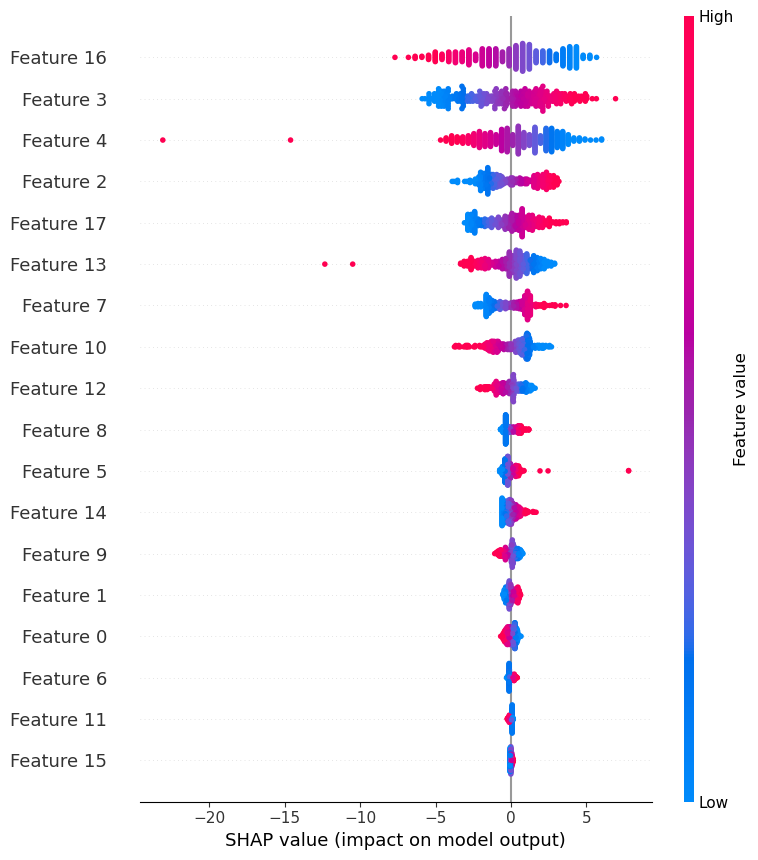

In [32]:
shap.summary_plot(shap_values_scaled, X_train_scaled)

Finally, write a function which transforms shap values to Logistic Regression coefficients. Their relations are described in the [docs](https://shap.readthedocs.io/en/latest/generated/shap.explainers.Linear.html).

*Note: This task main goal is your deeper understanding of the shap importance estimation process.*

In [33]:
shap_values_scaled.values.shape

(344, 18)

In [34]:
def get_coef_from_shap_values(shap_values, X_train_scaled):
    return np.mean(np.multiply(shap_values.values, X_train_scaled), axis=0)

In [35]:
lr_scaled_coef, get_coef_from_shap_values(shap_values_scaled, X_train_scaled)

(array([[-0.2798334 ,  0.29163505,  1.78591166,  2.86954384, -2.74410725,
          0.71342045,  0.15750468,  1.30255314,  0.44784977, -0.42163328,
         -1.28484987, -0.08762221, -0.81183178, -1.73047384,  0.45013935,
          0.05212563, -2.9261131 ,  1.68966497]]),
 array([-0.2798334 ,  0.29163505,  1.78591166,  2.86954384, -2.74410725,
         0.71342045,  0.15750468,  1.30255314,  0.44784977, -0.42163328,
        -1.28484987, -0.08762221, -0.81183178, -1.73047384,  0.45013935,
         0.05212563, -2.9261131 ,  1.68966497]))

In [36]:
coef_from_shap = get_coef_from_shap_values(shap_values_scaled, X_train_scaled)

If everything is correct, the next assert should pass.

In [37]:
assert np.allclose(coef_from_shap, lr_scaled_coef)

#### Training the GradientBoosting

In [38]:
gb_basic = GradientBoostingClassifier(n_estimators=100)
gb_basic.fit(X_train, y_train)

GradientBoostingClassifier()

In [39]:
gb_basic_feature_importances = gb_basic.feature_importances_

In [40]:
gb_scaled = GradientBoostingClassifier(n_estimators=100)
gb_scaled.fit(X_train_scaled, y_train)

GradientBoostingClassifier()

In [41]:
gb_scaled_feature_importances = gb_scaled.feature_importances_

In [42]:
assert np.allclose(
    gb_basic_feature_importances, gb_scaled_feature_importances, atol=1e-1
)
submission_dict["gb_basic_feature_importances"] = gb_basic_feature_importances

**Question:** Why are the feature importances so similar for scaled and unscaled data?

Because in tree-based models at each split we are working with feature independently. So we don't care about the scale of that feature.

#### Using shap to explain trees ensemble solution

In [44]:
explainer = shap.TreeExplainer(gb_scaled)
shap_values = explainer.shap_values(X_train)

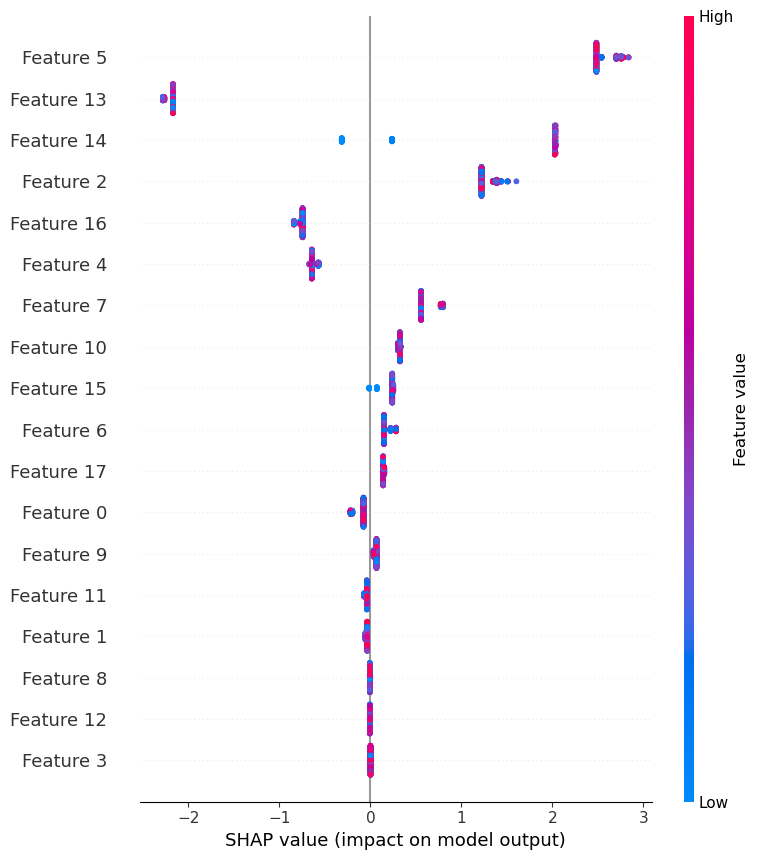

In [45]:
shap.summary_plot(shap_values, X_train)

In [46]:
gb_scaled_most_important_index = np.argmax(np.abs(np.mean(shap_values, axis=0)))

In [47]:
assert isinstance(int(gb_scaled_most_important_index), int)
submission_dict["gb_scaled_most_important_index"] = gb_scaled_most_important_index

In [210]:
np.save("submission_dict_hw08.npy", submission_dict, allow_pickle=True)
print("File saved to `submission_dict_hw.npy`")

File saved to `submission_dict_hw.npy`


Great job! Please, submit your solution to the grading system! Please, note, you need to submit both `submission_dict_hw.npy` and `get_coef_from_shap_values` function code.